In [538]:
import numpy as np
import matplotlib.pyplot as plt

gravConst = 6.6743 * (10**(-11)) 
mass_earth = 5.972 * (10**24)
mass_sun = 1.989 * (10**30)
mass_moon = 7.3483 * (10**22)
mass_moon = 3483 * (10**22)
distance_sun = 200 * (10**9)
distance_moon = 384 * (10**6)
year = 60 * 60 * 24* 365.25
track_earth = 2 * 147 * (10**9) * np.pi
track_moon = 2 * 384 * (10**6) * np.pi
velocity_earth = track_earth / year
velocity_moon = track_moon / year * 12

Defining a general class for a Particle with a mass a position and a velocity.

Where the actual mass is equal to
$$ \frac{self.mass}{\sqrt{G}}$$

In [539]:
class Particle:
    def __init__(self, name, mass, coord, velocity):
        self.name = name
        self.mass = mass
        self.coord = np.array([coord["x"], coord["y"], coord["z"]])
        self.velocity = np.array([velocity["x"],velocity["y"], velocity["z"]])
    
    def accelerate(self, force, dt):
        # delta is the velocity the particle is accelerated by in the timestep h
        a = force / self.mass
        delta = a * dt
        self.velocity = self.velocity + delta

    def move(self, dt):
        # delta is the distance the particle is moved by in the timestep h
        delta = self.velocity * dt
        self.coord = self.coord + delta

    def kineticEnergy(self):
        return self.mass / 2 * np.linalg.norm(self.velocity)**2

    def potEnergy(self, otherParticle):
        diff = np.subtract(self.coord, otherParticle.coord)
        radius = np.linalg.norm(diff)
        return - self.mass * otherParticle.mass / radius
    

Defining a function to calculate the gravitational force between 2 give Particles

In [540]:
def gravityForce(particle1, particle2):
    diff = np.subtract(particle2.coord, particle1.coord)
    radius = np.linalg.norm(diff)
    f_abs = particle1.mass * particle2.mass / (radius**2)
    #return force that applys on particle1
    return f_abs * (diff/radius) 
    




Create Particles

In [541]:

#star = Particle("sun", mass_sun*np.sqrt(gravConst), {"x": 0, "y": 0, "z": 0 },{"x": 0, "y": 0, "z": 0 } )
star = Particle("sun", 1000, {"x": 0, "y": 0, "z": 0 },{"x": -0.001, "y": 0, "z": 0 } )
#planet = Particle("earth", mass_earth*np.sqrt(gravConst), {"x": 0, "y": distance_sun, "z": 0 },{"x": velocity_earth, "y": 0, "z": 0 } )
planet1 = Particle("earth", 1, {"x": 0, "y": 1000, "z": 0 },{"x": 1, "y": 0, "z": 0 } )
planet2 = Particle("mars", 1, {"x": 1500, "y":0, "z": 0 },{"x": 0, "y": -0.8, "z": 0 } )
#moon = Particle("moon", mass_moon*np.sqrt(gravConst), {"x": distance_moon, "y": distance_sun, "z": 0 },{"x": velocity_earth, "y": velocity_moon, "z": 0 })
#moon = Particle("earth", 1, {"x": 0, "y": -1000, "z": 0 },{"x": -2, "y": 0, "z": 0 } )
particles = [star, planet1, planet2]

Verlet Algorithm

In [542]:
def verlet(particles, h, steps):
    t_axis = np.linspace(0, steps*h, num=steps)
    energy = np.zeros(steps)
    p_axes = []
    for p in particles:
        p_axes.append([np.zeros(steps), np.zeros(steps), np.zeros(steps)])

    for pti in particles:
        for ptj in particles: 
            if ptj == pti: continue
            force = gravityForce(pti, ptj)
            pti.accelerate(force, h/2)
            ptj.accelerate(-force, h/2)
    for i in range(steps):
        for p, pti in enumerate(particles):
            pti.move(h)
            force = np.zeros(3)
            for ptj in particles: 
                if pti == ptj: continue
                energy[i] += pti.potEnergy(ptj)
                force += gravityForce(pti, ptj)
         
            pti.accelerate(force, h)
            energy[i] += pti.kineticEnergy()
        
            p_axes[p][0][i] = pti.coord[0]
            p_axes[p][1][i] = pti.coord[1]
            p_axes[p][2][i] = pti.coord[2]
        if i/steps*100%10 == 0: 
            print(i/steps*100,"%")
    fig , ax = plt.subplots()
    for p, pt in enumerate(particles):
        ax.plot(p_axes[p][0],  p_axes[p][1], c=np.random.rand(3,), label=pt.name)
    
    
    plt.legend()
    plt.show()

    fig2 , ax2 = plt.subplots()
    ax2.plot(t_axis, energy, 'r-', label='energy')
    plt.legend()
    plt.show()



0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %


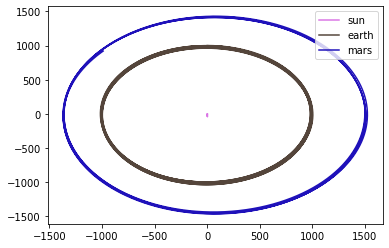

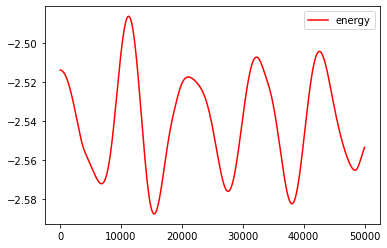

In [543]:

verlet(particles, 0.5, 100000)
#verlet(particles, 0.1, 60000)